In [1]:
import pyanitools as pyt
#import pyaniasetools as aat
import pyNeuroChem as pyc
import hdnntools as hdt
import numpy as np

from ase_interface import ANIENS
from ase_interface import ensemblemolecule
from ase.atoms import Atoms

import matplotlib.pyplot as plt

#import aniensemblestats as ens

/home/jujuman/.conda/envs/my-rdkit-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


van Der Waals correction will be unavailable. Please install ased3


In [2]:
#h5files = '/home/jujuman/Research/DataReductionMethods/modelCNOSFCl/initial/cv1/testset/testset1.h5'
#h5files = '/home/jujuman/Seagate2TB/Research/ANI-DATASET/h5data/ani_data_c10test.h5'
#h5files = '/home/jujuman/Research/extensibility_test_sets/gdb-10/gdb11_10_test500.h5'
h5files = '/home/jujuman/Scratch/Research/tin_research/model/testset/testset'

#wkdir = '/nh/nest/u/jsmith/scratch/Research/levi_test/ANI-2x_v62518'
wkdir = '/home/jujuman/Scratch/Research/tin_research/model/'

cns = wkdir + '/train0/rSn-7.5R_32-7.5A_a8-8.params'
sae = wkdir + '/train0/sae_linfit.dat'
nnf = wkdir + '/train'
Nn = 1

In [3]:
#anicv = aat.anicrossvalidationconformer(cns, sae, nnf, Nn, [0])
#nc = pyc.molecule(cns,sae,nnf+str(0)+'/networks/', 0)



In [4]:
#hfile = '/nh/nest/u/jsmith/Research/gutzwiller_research/new_converged_data/20180723-MD/N100/U10.0-N10-ANI.h5'
#dpack = pyt.datapacker(hfile)

In [5]:
Eani_t = []
Edft_t = []
dEani_t = []
dEdft_t = []
Fani_t = []
Fdft_t = []

for j in range(Nn):
    # Set NC
    aens = ensemblemolecule(cns, sae, nnf, 1, 0, net_start_id=j)

    L=16.0
    cell = np.array([[L, 0, 0],
                     [0, L, 0],
                     [0, 0, L]],dtype=np.float32)

    celi = (np.linalg.inv(cell)).astype(np.float32)

    aens.set_pbc(True,True,True)
    aens.set_cell((cell).astype(np.float32), celi)

    adl = pyt.anidataloader(h5files+str(j)+'.h5')
    #adl = pyt.anidataloader('/home/jujuman/Scratch/Research/tin_research/data-11.h5')
    
    for i,data in enumerate(adl):
        X = data['coordinates']
        S = data['species']
        Edft = hdt.hatokcal*data['energies']
        Fdft = hdt.hatokcal*data['forces'].flatten()


        #Fdft = data['forces']

        #if 'N' in S:
        Eani = []
        Fani = []
        for x in X:
            aens.set_molecule(x.astype(np.float32), S)
            energy, force, stddev, Fstddev = aens.compute_mean_props()
            Eani.append(energy)
            Fani.append(force.reshape(1,-1,3))

        Eani = hdt.hatokcal*np.array(Eani)
        Fani = hdt.hatokcal*np.vstack(Fani).flatten()

        print(Fani.shape)
        #Eani, Fani, Sig = anicv.compute_energyandforce_conformations(X=np.array(X,dtype=np.float32),S=S)
        #print(Fdft)
        #Eani = np.asarray(np.mean(Eani,axis=1))
        #print(Eani.shape,Edft.shape)
        #idx = np.where((Edft - Edft.min() < 300.0))
        #print(np.abs(Edft-Eani), len(S))

        #mina = Eani.min()
        #mind = Edft.min()

        Esae1 = hdt.hatokcal*hdt.compute_sae(sae,S)
        #Esae2 = hdt.hatokcal*hdt.compute_sae('/nh/nest/u/jsmith/scratch/Research/levi_test/train/sae_linfit.dat',S)
       
        Eani_t.append((Eani-Esae1)/len(S))
        Edft_t.append((Edft-Esae1)/len(S))
        print(Eani_t[-1])

        Fani_t.append(Fani)
        Fdft_t.append(Fdft)

        #dEani_t.append(hdt.calculatedmat(Eani))
        #dEdft_t.append(hdt.calculatedmat(Edft))
        #print(np.abs(-Fani[0]-hdt.hatokcal*Fdft))


Eani_t = np.concatenate(Eani_t)
Edft_t = np.concatenate(Edft_t)
Fani_t = np.concatenate(Fani_t)
Fdft_t = np.concatenate(Fdft_t)
#dEani_t = np.concatenate(dEani_t)
#dEdft_t = np.concatenate(dEdft_t)

new_data = dict()

new_data["species"] = S
new_data["coordinates"] = X
new_data["energies"] = Eani_t
new_data["forces"] = Fani_t

#dpack.store_data('/kt015/ANI',**new_data)
#dpack.cleanup()

/home/jujuman/Gits/NeuroChem/build/lib/ase_interface.py:530: RuntimeWarning: invalid value encountered in true_divide
  v2 = np.sum(np.sum(np.power(dF, 2), axis=0) / (self.Nn * (self.Nn - 1)))


(135,)
[3.75646096]
(174,)
[-3.89885669]
(168,)
[-2.70222892]
(171,)
[-21.27413052]
(162,)
[-18.62056913]
(204,)
[-20.82510852]
(261,)
[28.57005399]
(219,)
[18.25878887]
(252,)
[21.4271971]
(171,)
[-21.34520646]
(297,)
[42.57179783]
(264,)
[23.05782205]
(291,)
[36.59147243]
(294,)
[27.08508941]
(321,)
[42.5609465]
(192,)
[33.24930068]
(189,)
[29.30566916]
(414,)
[79.7395884]
(300,)
[29.36796551]
(375,)
[50.97752517]
(207,)
[51.52966265]
(159,)
[2.82570255]
(261,)
[18.9549316]
(219,)
[17.20817472]
(225,)
[28.74315421]
(255,)
[23.06657687]
(237,)
[28.27024862]
(276,)
[32.81888226]
(570,)
[33.82102343 28.46591528]
(282,)
[31.04514052]
(84,)
[12.63130854]
(81,)
[13.74908035]
(72,)
[15.56550712]


In [6]:
#print(,Fani_t)
#Eani_t = np.concatenate(Eani_t)
#Edft_t = np.concatenate(Edft_t)
#print(Eani_t.shape, Edft_t.shape)

print('ERMS:',hdt.calculaterootmeansqrerror(Eani_t,Edft_t))
print('EMAE:',hdt.calculatemeanabserror(Eani_t,Edft_t))
print('FRMS:',hdt.calculaterootmeansqrerror(Fani_t,Fdft_t))
print('FMAE:',hdt.calculatemeanabserror(Fani_t,Fdft_t))
#print(hdt.calculaterootmeansqrerror(dEani_t,dEdft_t))
#print(hdt.calculatemeanabserror(dEani_t,dEdft_t))
#print(Eani_t.size)

ERMS: 0.4605154549326796
EMAE: 0.3761107315412956
FRMS: 12.028228
FMAE: 8.382322


In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.backends.backend_pdf import PdfPages


# ----------------------------------
# Plot force histogram
# ----------------------------------
def plot_corr_dist(Xa, Xp, inset=True, xlabel='$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$', ylabel='$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$', figsize=[13,10], cmap=mpl.cm.viridis):
    Fmx = Xa.max()
    Fmn = Xa.min()

    label_size = 14
    mpl.rcParams['xtick.labelsize'] = label_size
    mpl.rcParams['ytick.labelsize'] = label_size

    fig, ax = plt.subplots(figsize=figsize)

    # Plot ground truth line
    ax.plot([Fmn, Fmx], [Fmn, Fmx], '--', c='r', linewidth=3)

    # Set labels
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)

    #cmap = mpl.cm.viridis
    #cmap = mpl.cm.brg

    # Plot 2d Histogram
    bins = ax.hist2d(Xa, Xp, bins=100, norm=LogNorm(), range= [[Xa.min(), Xa.max()], [Xp.min(), Xp.max()]], cmap=cmap)

    # Build color bar
    #cbaxes = fig.add_axes([0.91, 0.1, 0.03, 0.8])
    cb1 = fig.colorbar(bins[-1], cmap=cmap)
    cb1.set_label('Count', fontsize=16)

    # Annotate with errors
    PMAE = hdt.calculatemeanabserror(Xa, Xp)
    PRMS = hdt.calculaterootmeansqrerror(Xa, Xp)
    ax.text(0.75*((Fmx-Fmn))+Fmn, 0.43*((Fmx-Fmn))+Fmn, 'MAE='+"{:.3f}".format(PMAE)+'\nRMSE='+"{:.3f}".format(PRMS), fontsize=20,
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

    if inset:
        axins = zoomed_inset_axes(ax, 2.2, loc=2) # zoom = 6

        sz = 6
        axins.hist2d(Xa, Xp,bins=50, range=[[Fmn/sz, Fmx/sz], [Fmn/sz, Fmx/sz]], norm=LogNorm(), cmap=cmap)
        axins.plot([Xa.min(), Xa.max()], [Xa.min(), Xa.max()], '--', c='r', linewidth=3)

        # sub region of the original image
        x1, x2, y1, y2 = Fmn/sz, Fmx/sz, Fmn/sz, Fmx/sz
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.yaxis.tick_right()

        plt.xticks(visible=True)
        plt.yticks(visible=True)

        mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

        Ferr = Xa - Xp
        std = np.std(Ferr)
        men = np.mean(Ferr)
        axh = plt.axes([.49, .16, .235, .235])
        axh.hist(Ferr, bins=75, range=[men-4*std, men+4*std], normed=True)
        axh.set_title('Difference distribution')

    #plt.draw()
    plt.show()

In [8]:
from scipy import stats
Fgradient, Fintercept, r_value, p_value, std_err = stats.linregress(Fani_t,Fdft_t)
Egradient, Eintercept, r_value, p_value, std_err = stats.linregress(Eani_t,Edft_t)

In [9]:
print(Egradient,Eintercept,Fgradient)

1/.97

1.0078507200288613 -0.36471194059576817 0.998741667275157


1.0309278350515465

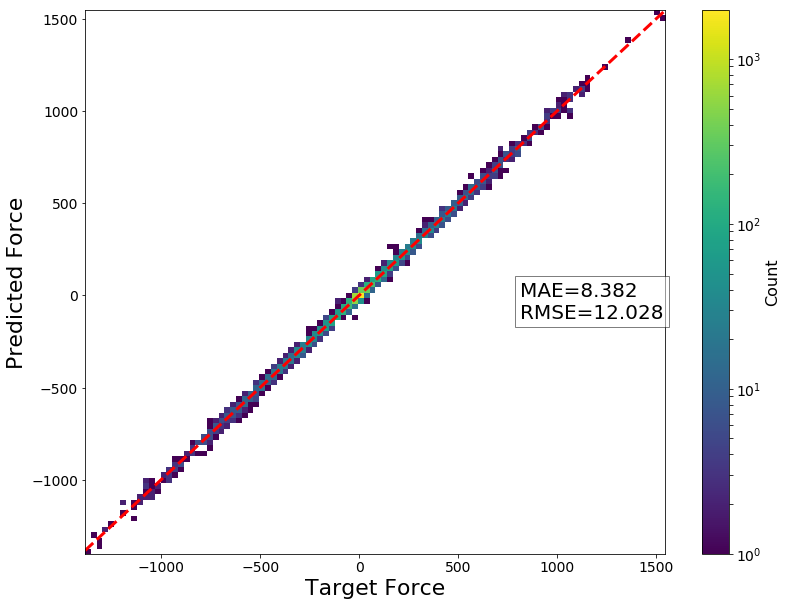

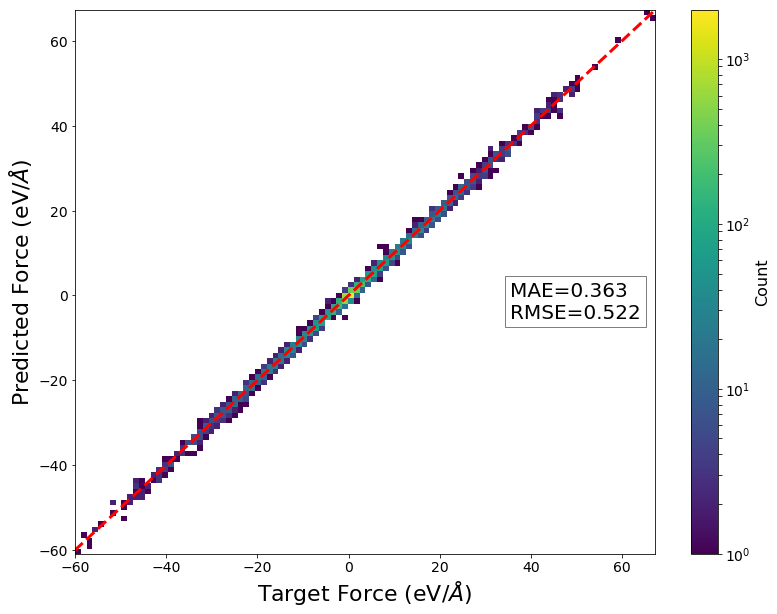

In [10]:
plot_corr_dist(Fdft_t,Fani_t,xlabel='Target Force',ylabel='Predicted Force',inset=False)
plot_corr_dist(Fdft_t/hdt.evtokcal,Fani_t/hdt.evtokcal,xlabel=r'Target Force (eV/$\AA$)',ylabel=r'Predicted Force (eV/$\AA$)',inset=False)

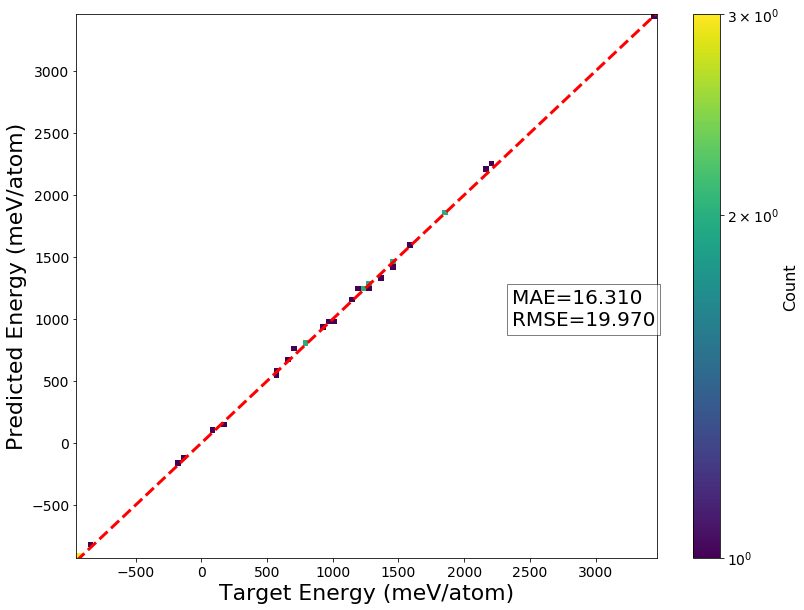

In [11]:
plot_corr_dist(1000.0*Edft_t/hdt.evtokcal,1000.0*Eani_t/hdt.evtokcal,xlabel='Target Energy (meV/atom)',ylabel='Predicted Energy (meV/atom)', inset=False)

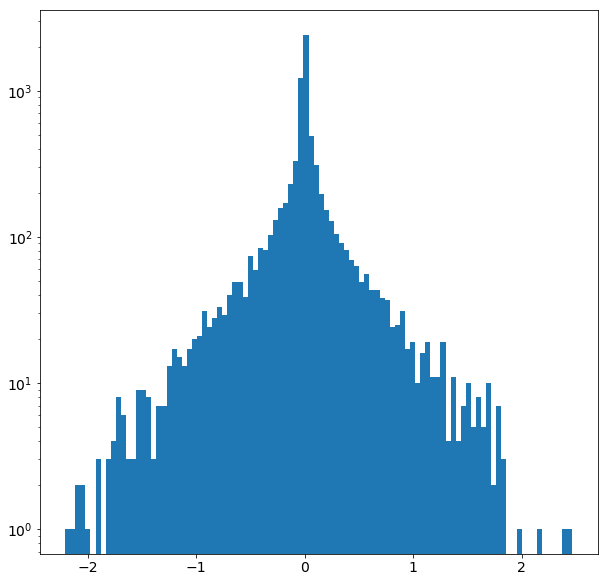

In [12]:
fig = plt.figure(figsize=[10,10])
idx = np.where(np.abs(Fdft_t)/hdt.hatokcal<3)
plt.hist(Fdft_t[idx]/hdt.hatokcal,bins=100)
plt.yscale("log")
plt.show()

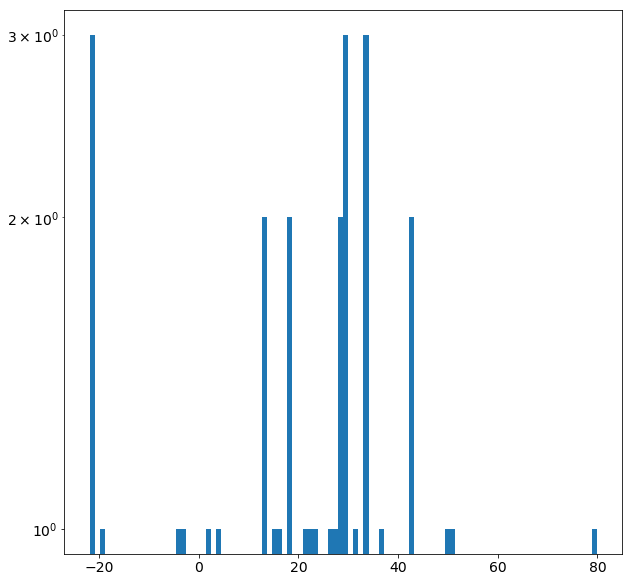

In [13]:
fig = plt.figure(figsize=[10,10])
plt.hist(Edft_t,bins=100)
plt.yscale("log")
plt.show()

In [14]:
fig = plt.figure(figsize=[10,10])
plt.hist(np.linalg.norm(Fdft_t,axis=1),bins=100)
plt.yscale("log")
plt.xlabel("Gutz force magnitude")
plt.ylabel("Count")
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

<Figure size 720x720 with 0 Axes>